# Objetivo

Avaliar quais das 180 features são mais importantes.

# Método

Aplicar correlação a cada um dos portfólios de forma individual e verificar se há relações entre as features.

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregamento do arquivo portfolio 1

In [2]:
port1 = pd.read_csv('analysis/estaticos_portfolio1.csv')
port1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Columns: 182 entries, Unnamed: 0 to qt_filiais
dtypes: bool(14), float64(142), int64(4), object(22)
memory usage: 736.1+ KB


In [3]:
port1.shape

(555, 182)

# Escolha de uma variável-alvo

Do ponto de vista de negócios, o nível de atividade ou o faturamento seriam variáveis interessantes.
Podemos testar, então:

- de_faixa_faturamento_estimado: character value, class of the estimated revenue of the company
- de_faixa_faturamento_estimado_grupo: character value, class of the sum of estimated revenue for the matrix company and branches
- vl_faturamento_estimado_aux: numeric value, value of the estimated revenue
- vl_faturamento_estimado_grupo_aux
- fl_optante_simei: boolean, true if the company is taxed as an MEI - Individual Micro Entrepreneur (Micro Empreendedor Individual)
- fl_mei: boolean value, true if the company has the term 'MEI' in the end of its legal name.
- de_nivel_atividade:character, probability of being operating, ALTA high probality, BAIXA, low probality.

In [4]:
# vamos testar as categorias
features_totest = ['de_faixa_faturamento_estimado', 'vl_faturamento_estimado_aux', 'fl_optante_simei', 
                  'fl_mei', 'de_nivel_atividade']

for feat in features_totest:
    print(feat, port1[feat].dtype)
    print(port1[feat].describe(), '\n')


de_faixa_faturamento_estimado object
count                                 530
unique                                  7
top       DE R$ 81.000,01 A R$ 360.000,00
freq                                  325
Name: de_faixa_faturamento_estimado, dtype: object 

vl_faturamento_estimado_aux float64
count    5.300000e+02
mean     3.218504e+05
std      1.005342e+06
min      0.000000e+00
25%      5.000000e+04
50%      2.100000e+05
75%      2.100000e+05
max      2.019427e+07
Name: vl_faturamento_estimado_aux, dtype: float64 

fl_optante_simei object
count       454
unique        2
top       False
freq        316
Name: fl_optante_simei, dtype: object 

fl_mei bool
count       555
unique        2
top       False
freq        337
Name: fl_mei, dtype: object 

de_nivel_atividade object
count       551
unique        4
top       MEDIA
freq        280
Name: de_nivel_atividade, dtype: object 



# Correlação

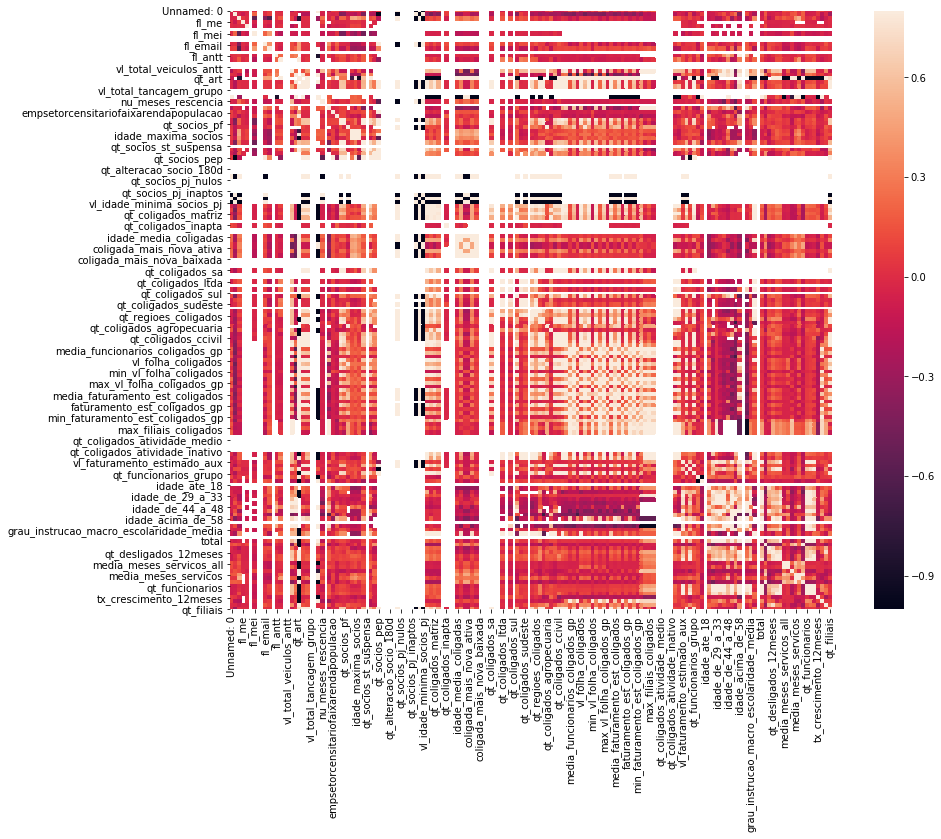

In [5]:
#correlation matrix
# lembrar que colunas do tipo object não entram na matriz
corrmat = port1.corr()
f, ax = plt.subplots(figsize=(15, 11))
sns.heatmap(corrmat, vmax=.8, square=True);

In [6]:
corrmat.shape
# lembrar que colunas do tipo object não entram na matriz

(160, 160)

## Valor de faturamento

In [12]:
#feature correlation matrix
k = 10 #number of variables for heatmap
corrmat.nlargest(k, 'vl_faturamento_estimado_aux')['vl_faturamento_estimado_aux']

qt_socios_pj_ativos                        1.000000
vl_idade_maxima_socios_pj                  1.000000
vl_faturamento_estimado_aux                1.000000
grau_instrucao_macro_escolaridade_media    0.914913
idade_de_29_a_33                           0.913919
idade_de_49_a_53                           0.884280
total                                      0.882779
qt_funcionarios                            0.881781
qt_funcionarios_12meses                    0.863465
qt_funcionarios_24meses                    0.854182
Name: vl_faturamento_estimado_aux, dtype: float64

In [9]:
port1['qt_socios_pj_ativos'].value_counts()

2.0    1
1.0    1
Name: qt_socios_pj_ativos, dtype: int64

In [10]:
port1['vl_idade_maxima_socios_pj'].value_counts()

19.334702    1
18.910335    1
Name: vl_idade_maxima_socios_pj, dtype: int64

### Conclusões

Usando o valor de faturamento `vl_faturamento_estimado_aux`,a correlação de algumas features são bem lógicas, como a quantidade/número de funcionários (que aparece em 7 features, desde `grau_instrucao_macro_escolaridade_media` até `qt_funcionarios_24meses`.

Não parece muito óbvia a correlação com `qt_socios_pj_ativos`, observando a contagem de valores com `value_counts()`, só há dois registros diferentes de NaN,  assim como em `vl_idade_maxima_socios_pj`.

Resumindo, para o valor de faturamento, quanto mais funcionários, maior o faturamento.

## Nível de atividade

Como a correlação que apareceu com o valor de faturamento não parece muito valiosa, `de_nivel_atividade` é a próxima feature a analisar. Só que a correlação não é calculada para colunas do tipo `object`. Então, primeiro é necessário convertê-la. Vamos usar _LabelEncoder_. Só que o _encoder_ não funciona se houver NaN. Vamos conferir.

In [34]:
sum(port1['de_nivel_atividade'].isna())

4

Como são só 4, vou excluí-los.

In [35]:
port1.shape

(555, 182)

In [36]:
port1.dropna(subset=['de_nivel_atividade'], inplace = True)

In [37]:
port1.shape

(551, 182)

In [38]:
port1['de_nivel_atividade'].value_counts()

MEDIA          280
ALTA           153
BAIXA          116
MUITO BAIXA      2
Name: de_nivel_atividade, dtype: int64

In [39]:
#https://chrisalbon.com/machine_learning/preprocessing_structured_data/convert_pandas_categorical_column_into_integers_for_scikit-learn/
from sklearn import preprocessing
# Create a label (category) encoder object
le = preprocessing.LabelEncoder()

In [43]:
# Fit the encoder to the pandas column
le.fit(port1['de_nivel_atividade'])
# View the labels (if you want)
list(le.classes_)

['ALTA', 'BAIXA', 'MEDIA', 'MUITO BAIXA']

In [45]:
# Apply the fitted encoder to the pandas column
port1['de_nivel_atividade_enc'] = le.transform(port1['de_nivel_atividade']) 

Então agora tenho uma nova coluna: `de_nivel_atividade_enc`. Vou refazer a matriz de correlação.

In [46]:
#correlation matrix
corrmat = port1.corr()
#feature correlation matrix
k = 10 #number of variables for heatmap
corrmat.nlargest(k, 'de_nivel_atividade_enc')['de_nivel_atividade_enc']

de_nivel_atividade_enc       1.000000
meses_ultima_contratacaco    0.476445
min_meses_servicos           0.413328
qt_socios_pep                0.333333
max_filiais_coligados        0.273027
min_meses_servicos_all       0.272227
qt_coligados_serviço         0.245172
total_filiais_coligados      0.241344
min_vl_folha_coligados_gp    0.208508
media_filiais_coligados      0.206329
Name: de_nivel_atividade_enc, dtype: float64

### Conclusões
Usando `de_nivel_atividade_enc`, a  correlação não é muito alta com nenhuma feature. Talvez as duas primeiras sejam interessantes:

- `meses_ultima_contratacaco`, que indica há quantos meses o último funcionário foi contratado
- `min_meses_servicos`, que indica o número médio de meses trabalhados pelos funcionários ativos